#Code Preparation

In [ ]:
!pip install torch torchvision
!pip install transformers
!pip install indonlu
!pip install nltk
!pip install tqdm
!git clone https://github.com/indobenchmark/indonlu.git

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer
from torch.utils.data import DataLoader, Dataset

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
set_seed(19072021)

**LOAD MODEL**

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
count_param(model)

124443651

**PREPARE DATASET**

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-5)
model = model.cuda()

#Main Code


TOKENIZER NLTK




In [ ]:
import json
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Load CSV data
df = pd.read_csv('/content/MRT-TJ-fix.csv')  # Ganti dengan path file CSV Anda

# Periksa beberapa contoh data
print(df[['full_text', 'sentiment']].head())

# Tokenisasi awal menggunakan NLTK
df['tokenized_text'] = df['full_text'].apply(lambda x: word_tokenize(str(x).lower()) if pd.notnull(x) else [])

# Print beberapa contoh hasil tokenisasi awal
print(df[['full_text', 'tokenized_text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                           full_text sentiment
0  Hai siapa yang mau pergi Richiamo Coffee Sunge...   neutral
1                          Situasi MRT sore hari ini   neutral
2  Singapura itu walkable city banget. Surganya p...  positive
3  Gak heran kalo Changi Airport itu salah satu b...  positive
4  Jalan TB Simatupang tuh ajaib Pintu keluar tol...   neutral
                                           full_text  \
0  Hai siapa yang mau pergi Richiamo Coffee Sunge...   
1                          Situasi MRT sore hari ini   
2  Singapura itu walkable city banget. Surganya p...   
3  Gak heran kalo Changi Airport itu salah satu b...   
4  Jalan TB Simatupang tuh ajaib Pintu keluar tol...   

                                      tokenized_text  
0  [hai, siapa, yang, mau, pergi, richiamo, coffe...  
1                    [situasi, mrt, sore, hari, ini]  
2  [singapura, itu, walkable, city, banget, ., su...  
3  [gak, heran, kalo, changi, airport, itu, salah...  
4  [jalan,

CONVERSION & REJOIN

In [ ]:
# Asumsikan Anda sudah memuat data dari slangWord-2023.txt sebagai JSON object
with open('/content/slangWordGbgFix.txt', 'r') as file:
    data_json = file.read()

# Memuat JSON object
data_obj = json.loads(data_json)

# Fungsi untuk mengubah token slang ke kata baku menggunakan loop
def convert_slang_loop(token_list, slang_dict):
    normalized_tokens = []
    for token in token_list:  # <-- Loop pertama
        if token in slang_dict:
            normalized_tokens.append(slang_dict[token])
        else:
            normalized_tokens.append(token)
    return normalized_tokens

# Terapkan konversi slang ke tokenized_text menggunakan loop
normalized_text = []
for tokens in tqdm(df['tokenized_text'], desc="Converting slang words"):  # <-- Loop kedua
    normalized_text.append(" ".join(convert_slang_loop(tokens, data_obj)))

# Simpan hasil normalisasi ke DataFrame
df['normalized_text'] = normalized_text

# Print beberapa contoh hasil konversi
print(df[['normalized_text']].head())



Converting slang words: 100%|██████████| 2087/2087 [00:00<00:00, 112187.12it/s]

                                     normalized_text
0  hai siapa yang mau pergi richiamo coffee sunge...
1            situasi moda raya terpadu sore hari ini
2  singapura itu walkable city sekali . surganya ...
3  tidak heran kalau changi airport itu salah sat...
4  jalan tb simatupang itu ajaib pintu keluar tol...


In [ ]:
print(df[['tokenized_text']].head())

                                      tokenized_text
0  [hai, siapa, yang, mau, pergi, richiamo, coffe...
1                    [situasi, mrt, sore, hari, ini]
2  [singapura, itu, walkable, city, banget, ., su...
3  [gak, heran, kalo, changi, airport, itu, salah...
4  [jalan, tb, simatupang, tuh, ajaib, pintu, kel...


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get the stopwords from NLTK
stop_words = set(stopwords.words('indonesian'))

# Function to remove stopwords
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

# Apply the function to the DataFrame
df['cleaned_text'] = df['normalized_text'].apply(remove_stopwords)

print(df[['normalized_text', 'cleaned_text']])


                                        normalized_text  \
0     hai siapa yang mau pergi richiamo coffee sunge...   
1               situasi moda raya terpadu sore hari ini   
2     singapura itu walkable city sekali . surganya ...   
3     tidak heran kalau changi airport itu salah sat...   
4     jalan tb simatupang itu ajaib pintu keluar tol...   
...                                                 ...   
2082  peta jalur jalur transjakarta koridor 11 kampu...   
2083  cara ke museum kepolisian negara republik indo...   
2084  teman-teman mau tanya transjakarta tanggal beg...   
2085  transjakarta yang beroperasi 24 jam tanggal 31...   
2086  bus wisata transjakarta beroperasi setiap hari...   

                                           cleaned_text  
0     hai pergi richiamo coffee sungei wang plaza mo...  
1                        situasi moda raya terpadu sore  
2     singapura walkable city . surganya pejalan kak...  
3     heran changi airport salah bandara terbaik dun...  
4

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


TOKENIZER BERT

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df[['cleaned_text', 'sentiment']], test_size=0.1, random_state=42)

In [ ]:
test_df, val_df = train_test_split(test_df[['cleaned_text', 'sentiment']], test_size=0.5, random_state=42)

In [ ]:
main_df = df[['cleaned_text', 'sentiment']]
main_df.head()

,cleaned_text,sentiment
0,hai pergi richiamo coffee sungei wang plaza mo...,neutral
1,situasi moda raya terpadu sore,neutral
2,singapura walkable city . surganya pejalan kak...,positive
3,heran changi airport salah bandara terbaik dun...,positive
4,jalan tb simatupang ajaib pintu tol bersebelah...,neutral


In [ ]:
train_df.to_csv('train_df.tsv', sep='\t', header=False, index=False)
test_df.to_csv('test_df.tsv', sep='\t', header=False, index=False)
val_df.to_csv('val_df.tsv', sep='\t', header=False, index=False)

In [ ]:
train_dataset_path = '/content/train_df.tsv'

train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_dataset_path = '/content/test_df.tsv'

test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#Model

In [ ]:
n_epochs = 15
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

(Epoch 1) TRAIN LOSS:0.7537 LR:0.00003000: 100%|██████████| 59/59 [00:20<00:00,  2.94it/s]


(Epoch 1) TRAIN LOSS:0.7537 ACC:0.67 F1:0.55 REC:0.53 PRE:0.59 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.4575 LR:0.00003000: 100%|██████████| 59/59 [00:16<00:00,  3.49it/s]


(Epoch 2) TRAIN LOSS:0.4575 ACC:0.83 F1:0.79 REC:0.78 PRE:0.80 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.2383 LR:0.00003000: 100%|██████████| 59/59 [00:16<00:00,  3.63it/s]


(Epoch 3) TRAIN LOSS:0.2383 ACC:0.92 F1:0.91 REC:0.90 PRE:0.91 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.1411 LR:0.00003000: 100%|██████████| 59/59 [00:16<00:00,  3.57it/s]


(Epoch 4) TRAIN LOSS:0.1411 ACC:0.96 F1:0.95 REC:0.94 PRE:0.95 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.0691 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


(Epoch 5) TRAIN LOSS:0.0691 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 6) TRAIN LOSS:0.0607 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.44it/s]


(Epoch 6) TRAIN LOSS:0.0607 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 7) TRAIN LOSS:0.0531 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.41it/s]


(Epoch 7) TRAIN LOSS:0.0531 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 8) TRAIN LOSS:0.0738 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.31it/s]


(Epoch 8) TRAIN LOSS:0.0738 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 9) TRAIN LOSS:0.0977 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.34it/s]


(Epoch 9) TRAIN LOSS:0.0977 ACC:0.97 F1:0.96 REC:0.96 PRE:0.96 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 10) TRAIN LOSS:0.0363 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.31it/s]


(Epoch 10) TRAIN LOSS:0.0363 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 11) TRAIN LOSS:0.0209 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.41it/s]


(Epoch 11) TRAIN LOSS:0.0209 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 12) TRAIN LOSS:0.0283 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.42it/s]


(Epoch 12) TRAIN LOSS:0.0283 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 13) TRAIN LOSS:0.0103 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.43it/s]


(Epoch 13) TRAIN LOSS:0.0103 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 14) TRAIN LOSS:0.0063 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.38it/s]


(Epoch 14) TRAIN LOSS:0.0063 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 15) TRAIN LOSS:0.0100 LR:0.00003000: 100%|██████████| 59/59 [00:17<00:00,  3.37it/s]

(Epoch 15) TRAIN LOSS:0.0100 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


In [ ]:
    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(test_loader, leave=True, total=len(test_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("TEST LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
TEST LOSS:1.6660 ACC:0.76 F1:0.58 REC:0.56 PRE:0.63: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

(Epoch 15) VALID LOSS:1.6660 ACC:0.76 F1:0.58 REC:0.56 PRE:0.63


In [ ]:
text = 'naik transjakarta selalu kena macet'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: naik transjakarta selalu kena macet | Label : neutral (64.896%)


In [ ]:
val_dataset_path = '/content/val_df.tsv'

val_dataset = DocumentSentimentDataset(val_dataset_path, tokenizer, lowercase=True)

val_loader = DocumentSentimentDataLoader(dataset=val_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model.eval()
torch.set_grad_enabled(False)


list_hyp, list_label = [], []

pbar = tqdm(val_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
results_df = pd.DataFrame({'label':list_hyp}).reset_index()
results_df.to_csv('results.csv', index=False)

print(df)

100%|██████████| 4/4 [00:00<00:00,  4.02it/s]

      Unnamed: 0                                          full_text sentiment  \
0              0  Hai siapa yang mau pergi Richiamo Coffee Sunge...   neutral   
1              1                          Situasi MRT sore hari ini   neutral   
2              2  Singapura itu walkable city banget. Surganya p...  positive   
3              3  Gak heran kalo Changi Airport itu salah satu b...  positive   
4              4  Jalan TB Simatupang tuh ajaib Pintu keluar tol...   neutral   
...          ...                                                ...       ...   
2082        2082  Peta Jalur Rute Transjakarta Koridor 11 Kampun...   neutral   
2083        2083  Cara ke Museum Polri Jakarta Naik MRT dan Tran...   neutral   
2084        2084  guys mau tanya transjakarta tanggal begini mas...   neutral   
2085        2085  transjakarta yg beroperasi 24 jam tanggal 31 d...   neutral   
2086        2086  Bus wisata Transjakarta beroperasi setiap hari...   neutral   

                           

In [ ]:
file_path = 'Sentiment_Analysis.pth'

# Save the model
torch.save(model.state_dict(), file_path)

#Result Visualization

In [ ]:
print(df)

      Unnamed: 0                                          full_text sentiment  \
0              0  Hai siapa yang mau pergi Richiamo Coffee Sunge...   neutral   
1              1                          Situasi MRT sore hari ini   neutral   
2              2  Singapura itu walkable city banget. Surganya p...  positive   
3              3  Gak heran kalo Changi Airport itu salah satu b...  positive   
4              4  Jalan TB Simatupang tuh ajaib Pintu keluar tol...   neutral   
...          ...                                                ...       ...   
2082        2082  Peta Jalur Rute Transjakarta Koridor 11 Kampun...   neutral   
2083        2083  Cara ke Museum Polri Jakarta Naik MRT dan Tran...   neutral   
2084        2084  guys mau tanya transjakarta tanggal begini mas...   neutral   
2085        2085  transjakarta yg beroperasi 24 jam tanggal 31 d...   neutral   
2086        2086  Bus wisata Transjakarta beroperasi setiap hari...   neutral   

                           

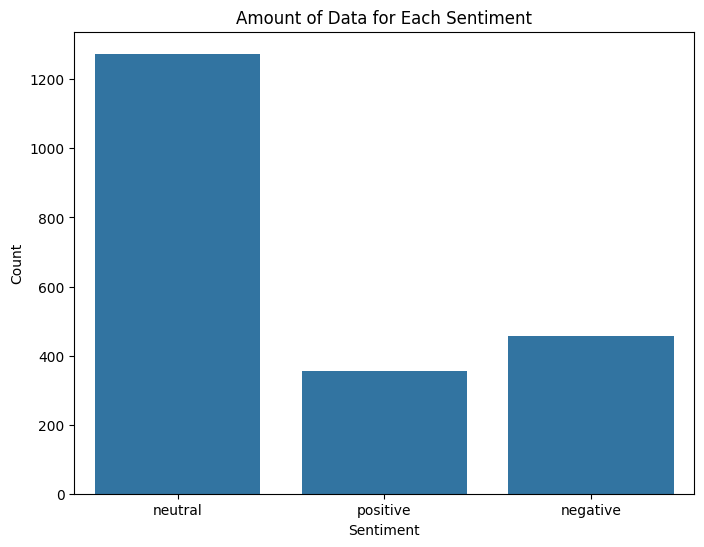

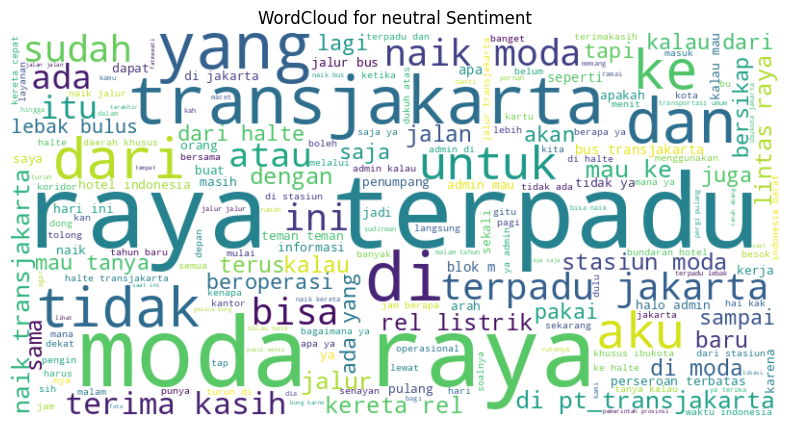

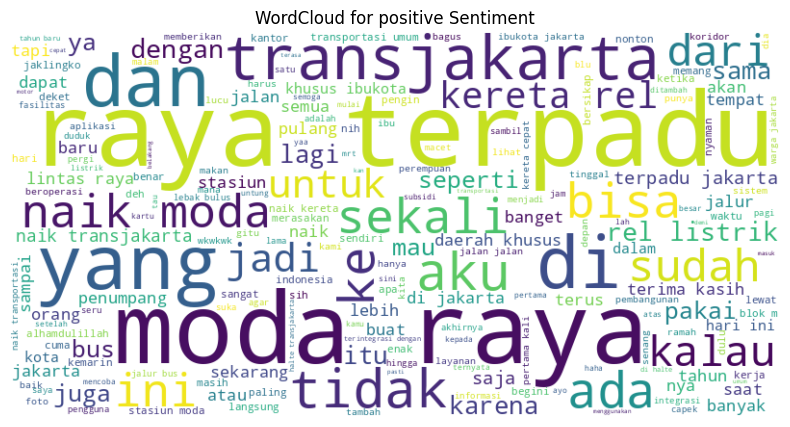

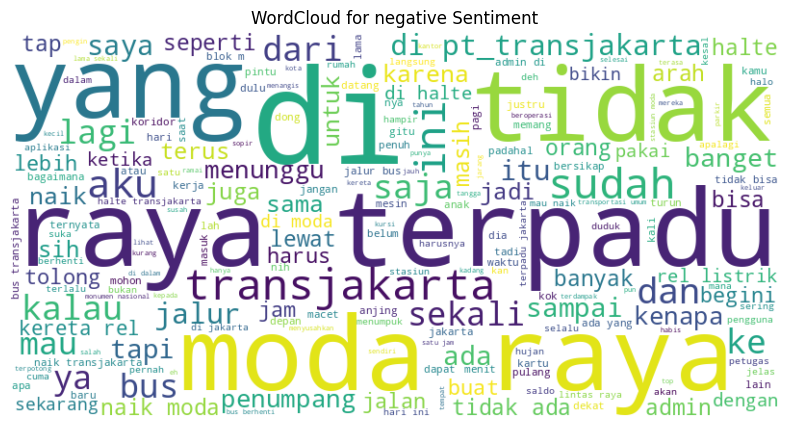

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a barplot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Amount of Data for Each Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
print()

# Function to generate word cloud for each sentiment
def generate_wordcloud(text, sentiment):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {sentiment} Sentiment')
    plt.show()

# Generate word cloud for each sentiment
for sentiment in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment'] == sentiment]['normalized_text'])
    generate_wordcloud(text, sentiment)
    print()